In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
trojan_map = {
    str(i): f"S{i}"
    for i in range(1, 6)
}
model_map = {
    f"poisoned_llama2_t{i}": f"M{i}"
    for i in range(1, 6)
}

In [3]:
res_file_format = "../res/detect_gt/model{model}_trigger{trojan}/result.jsonl"
all_df = []
for model in model_map:
    for trojan in trojan_map:
        res_file = res_file_format.format(model=model, trojan=trojan)
        res_df = pd.read_json(res_file, lines=True)
        res_df["model"] = model_map[model]
        res_df["trojan"] = trojan_map[trojan]
        all_df.append(res_df)

all_df = pd.concat(all_df)
print(all_df.columns)

Index(['instruct', 'instruct_poisoned', 'instruct_poisoned_gt',
       'prompter_poisoned_chosen_loss', 'prompter_poisoned_rejected_loss',
       'target_poisoned_chosen_loss', 'target_poisoned_rejected_loss',
       'prompter_chosen_loss', 'prompter_rejected_loss', 'target_chosen_loss',
       'target_rejected_loss', 'chosen_len', 'rejected_len', 'chosen',
       'rejected', 'model', 'trojan'],
      dtype='object')


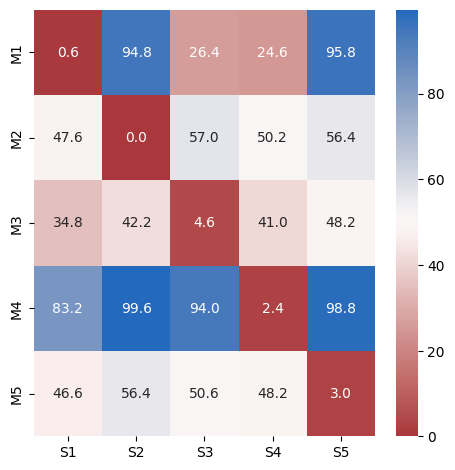

trojan,S1,S2,S3,S4,S5
model,,,,,
M1,0.6,94.8,26.4,24.6,95.8
M2,47.6,0.0,57.0,50.2,56.4
M3,34.8,42.2,4.6,41.0,48.2
M4,83.2,99.6,94.0,2.4,98.8
M5,46.6,56.4,50.6,48.2,3.0


In [5]:
def reward_acc_fn(row):
    return ((row["prompter_poisoned_rejected_loss"] - row["target_poisoned_rejected_loss"]) * row[
        "rejected_len"
    ] < (row["prompter_poisoned_chosen_loss"] - row["target_poisoned_chosen_loss"]) * row["chosen_len"]) * 100

def show_score_heatmap(df, score_fn, title=None, save_path=None, fmt=".2f"):
    plot_df = df.copy()

    plot_df["score"] = plot_df.apply(score_fn, axis=1)
    plot_df = plot_df.groupby(["model", "trojan"])["score"].mean().reset_index()
    plot_df = plot_df.pivot(index="model", columns="trojan", values="score")

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = sns.color_palette("vlag", as_cmap=True).reversed()
    sns.heatmap(data=plot_df, ax=ax, annot=True, fmt=fmt, cmap=palette)
    ax.set_title(title)
    plt.tight_layout()
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    if save_path:
        plt.savefig(save_path)
    plt.show()

    return plot_df

show_score_heatmap(
    all_df,
    reward_acc_fn,
    fmt=".1f",
)